In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(precision=2) 

# we set the random seed to make our results deterministic
# (same results across runs)
# on définit un noyau pour rendre nos résultats déterministes
# (pour que tout le monde ait les mêmes resultats.)
np.random.seed(2)

# On losses and gradients

We consider labeled data $(\mathbf{x},y)$, where $\mathbf{x}$ is a $d$-dimensional input, i.e. $\mathbf{x} \in \mathbb{R}^{d}$ and $y\in\{-1,1\}$. We have a dataset of $n$ such pairs $(\mathbf{x}_i,y_i)$. We want to train a linear classifier on this dataset. The classifier predicts the label
$$f( \mathbf{x} ; \mathbf{w}, b) = \text{sign}(\mathbf{w}^T \mathbf{x} + b)
=
\begin{cases}
+1 \quad \text{if}\quad \mathbf{w}^T x + b \geq 0 \quad\text{and}\\ -1 \quad\text{otherwise.}
\end{cases}
$$

To simplify code and notation, we can get rid of the bias term $b$. To do  so, we concatenate $1$ to every $\mathbf{x}$ vector, so that $\mathbf{x}' = (\mathbf{x}, 1) \in \mathbb{R}^{d+1}$, and we concatenate $b$ to $\mathbf{w}$, so that $\mathbf{w}' = (\mathbf{w}, b)$. Then $\mathbf{w}^T \mathbf{x} + b = \mathbf{w}'^T \mathbf{x}'$. We can write everything in terms of linear transformations instead of affine transformations.

We will omit the bias term from now on, and consider $\mathbf{x}$ and $\mathbf{w}$ themselves as $\mathbf{x}'$ and $\mathbf{w}'$.

The training error is defined as the average number of mistakes
$$\text{Error}(\mathbf{w}) = \frac{1}{n}\sum_{i=1}^n \mathbb{1}\{y_i \neq f(\mathbf{x}_i ; \mathbf{w}) \}$$
where $\mathbb{1}\{A\}$ is the indicator function, i.e. it is $1$ when $A$ is true, and $0$ otherwise.

**Exercise:** Minimizing this error directly using gradient descent is extremely hard. *Why ?*

**Answer**: The above loss function is non-convex and flat in large areas. Hence, gradient-based methods won't work.

Instead we are going to try minimizing 4 different losses. These losses are called *convex surrogate* losses. They are convex and have a gradient so we can optimize them with gradient descent.
1. Linear regression with MSE: $g(\mathbf{w}; \mathbf{x}, y) = \frac{1}{2}(\mathbf{x}^T \mathbf{w} - y)^2$.
2. Perceptron: $g(\mathbf{w}; \mathbf{x}, y) = \max(0, -y\ \mathbf{x}^T \mathbf{w})$.
3. SVM: $g(\mathbf{w}; \mathbf{x}, y) = \max(0, 1 - y\ \mathbf{x}^T \mathbf{w})$.
4. Logistic regression: $g(\mathbf{w}; \mathbf{x}, y) = \log( 1 + e^{- y\ \mathbf{x}^T \mathbf{w}})$.

The training objective that we are going to minimize is the average of the losses over each training example plus an $\ell^2$ regularization with hyperparameter $\lambda$:
$$L(w) = \frac{1}{n}\sum_{i=1}^n g(\mathbf{w}; \mathbf{x}_i, y_i) + \frac{\lambda}{2} \| \mathbf{w}\|^2 $$

Note that for the SVM, the regularization term is necessary to find the largest margin.

**Excercise:** Plot the error counter $\mathbb{1}\{y \neq z \}$, where $z = \mathbf{x}^T \mathbf{w}$.

**Exercise:** Plot all the surrogate losses as a function of $z = \mathbf{x}^T \mathbf{w}$.

In [ ]:
def error_counter(z, y):
  return (z*y<0).astype(int)# WRITE CODE HERE
  
def linearloss(z, y):
  return 0.5*(z-y)**2# WRITE CODE HERE

def perceptronloss(z, y):
  return np.maximum(0, -y*z)# WRITE CODE HERE

def svmloss(z, y):
  return np.maximum(0, 1- y*z)# WRITE CODE HERE

def logisticloss(z, y):
  return np.log(1+np.exp(-y*z))# WRITE CODE HERE

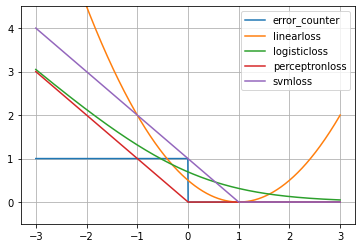

In [ ]:
zz = np.linspace(-3,3,1000)
plt.figure()
for loss in [error_counter, linearloss, logisticloss, perceptronloss, svmloss]:
    plt.plot(zz, loss(zz, np.array([1]*len(zz))), label=loss.__name__)

plt.ylim(-.5, 4.5)
plt.legend()
plt.grid()
plt.show()

**Exercise:** Compute the gradient of each of the losses above with respect to $\mathbf{w}$. You will need to code them later.

**Bonus Exercise:** All of these losses have a gradient that is expressed as a scalar times $\mathbf{x}$. Again, plot these scalar parts, assuming that $y=1$.

## 1. Data Preprocessing

We will again deal with the IRIS dataset.

For binary classification, we will only use two classes: class 1 and class 2. We will preprocess the dataset to extract only examples of these two classes, and for simplicity we will change their labels to be 1 and -1.

For easy visualization of the decision boundaries, we will also use only 2 input features.

Here is the code for the preprocessing:

In [ ]:
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    iris = np.loadtxt('http://www.iro.umontreal.ca/~dift3395/files/iris.txt')
else:
    iris = np.loadtxt('iris.txt')

def preprocess(data, label_subset, feature_subset, n_train):
    
    """Randomly split data into a train and test set 
    with the subset of classes in label_subset and the subset
    of features in feature_subset.
    """
    # extract only data with class label in label_subset
    data = data[np.isin(data[:, -1], label_subset), :]
    
    # remap labels to [-1, 1]
    if len(label_subset) != 2:
        raise UserWarning('We are exclusively dealing with binary classification.')
    data[data[:, -1]==label_subset[0], -1] = -1
    data[data[:, -1]==label_subset[1], -1] = 1

    # extract chosen features + labels
    data = data[:, feature_subset + [-1]]
    
    # insert a column of 1s for the bias
    data = np.insert(data, -1, 1, axis=1)

    # separate into train and test
    inds = np.arange(data.shape[0])
    np.random.shuffle(inds)
    train_inds = inds[:n_train]
    test_inds = inds[n_train:]
    trainset = data[train_inds] 
    testset = data[test_inds]

    # Normalize train set to mean 0 and standard deviation 1 feature-wise.
    # Apply the same transformation to the test set.
    mu = trainset[:, :2].mean(axis=0)
    sigma  = trainset[:, :2].std(axis=0)
    trainset[:, :2] = (trainset[:, :2] - mu)/sigma
    testset[:, :2] = (testset[:, :2] - mu)/sigma

    return trainset, testset


trainset, testset = preprocess(iris, label_subset=[1, 2], feature_subset=[2, 3], n_train=75)

## 2. Some helper functions

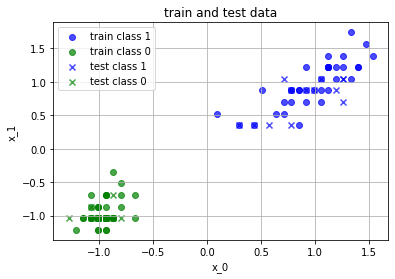

In [ ]:
def scatter(theset, marker='o', text=""):
    d1 = theset[theset[:, -1] > 0]
    d2 = theset[theset[:, -1] < 0]
    plt.scatter(d1[:, 0], d1[:, 1], c='b', marker=marker, label=f'{text} class 1', alpha=.7)
    plt.scatter(d2[:, 0], d2[:, 1], c='g', marker=marker, label=f'{text} class 0', alpha=.7)
    plt.xlabel('x_0')
    plt.ylabel('x_1')


def finalize_plot(title):
    plt.title(title)
    plt.grid()
    plt.legend()

scatter(trainset, marker='o', text="train")
scatter(testset, marker='x', text="test")
finalize_plot('train and test data')

### Decision boundary

Below, we will visualize the decision boundary of the models we will train. Since the decision rule is the same for all models, finding the decision boundary is also the same procedure.

Specifically, we isolate those $\mathbf{x}$ that satisfy $f(\mathbf{x}) = 0 \implies \mathbf{x}^{T}\mathbf{w} = 0$.

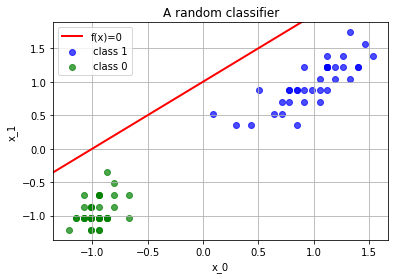

In [ ]:
def decision_boundary(w):
    if w[1] == 0:
        raise RuntimeWarning("This decision boundary is either vertical or undefined.")

    # hack to avoid changing the boundaries
    xlim = plt.xlim()
    ylim = plt.ylim()

    x_0 = np.linspace(-10, 10, 100)
    #    x^T w = 0 => (x_0, x_1, 1)^T (w_0, w_1, w_2) = 0
    # => x_1 = -(w_2 + x_0*w_0)/w_1
    x_1 = -(w[2] + x_0*w[0])/w[1]
    plt.plot(x_0, x_1, c='r', lw=2, label='f(x)=0')

    # hack to avoid changing the boundaries
    plt.xlim(xlim)
    plt.ylim(ylim)

w0 = np.array([1, -1, 1])
scatter(trainset)
decision_boundary(w0)
finalize_plot('A random classifier')

## 3. Base Class

We define here a *base* class (or *parent* class) `LinearModel` that we will pass in our *derived* classes (or *child* classes) below. Hence, when calling the function `super().__init__` in our derived classes, we inherit attributes without needing to implement them again. We have one derived class for each linear classifier and in these classes.

In the child classes, the methods `loss` and `gradient` methods will be re-defined according to that child's algorithm, e.g. Linear Regressio or Perceptron or SVM.

### 3.1 Train
We want to minimize the loss $L$. It is differentiable, so we can use the gradient descent algorithm: start from any initialization parameter $\mathbf{w}_0$, and repeat for $t\in\{0, \dots, t_\max \}$:
$$\mathbf{w}_{t+1} = \mathbf{w}_t - \eta\ \nabla L (\mathbf{w}_t) \; .$$

Under some conditions on the step-size $\eta$ and the loss $L$, this algorithm is guaranteed to converge to a minimum of $L$.

**Exercise**: Complete `train` in base class `LinearModel`.

You will need to fill in the `for` loop in the `train` function. Each step of this loop should update the parameter $\mathbf{w}$ by performing a gradient descent step, and then update the lists `losses` and `errors`.


### 3.2 Predict function

`predict` function should return the predictions of the model, given a batch of data `X` (matrix of size $n_{examples} \times n_{features}$)

**Exercise**: Complete the `predict` function in the base class `LinearModel`.

### 3.3 Test function
`test` function takes a batch of data `X` (matrix of size $n_{examples} \times n_{features}$) alongside their labels `y` (array of size $n_{examples}$) and returns the error rate for this batch.

**Exercise**: Complete the `test` function.

In [ ]:
from IPython.display import clear_output

class LinearModel:
    """"Abstract class for all linear models.
    """

    def __init__(self, w0, reg):
        """The linear weights and bias are in w, a matrix of size n_features x 1 (i.e. an array of size n_features).
        The regularization hyperparameter is reg.
        """
        self.w = np.array(w0, dtype=float)
        self.reg = reg

    def predict(self, X):
        """Return f(x) for a batch X.
        X is a matrix of size n_examples x n_features.
        Returns an array of size n_examples.
        """
        # WRITE CODE HERE
        return np.dot(X, self.w) #np.zeros(X.shape[0])

    def error_rate(self, X, y): 
        """Return the error rate for a batch X.
        X is a matrix of size n_examples x n_features.
        y is an array of size n_examples.
        Returns a scalar.
        """
        # WRITE CODE HERE
        return np.mean(self.predict(X)*y < 0)#0.

    # Dummy; will be redefined in child classes
    def loss(self, X, y):
        """Computes the mean loss for batch X.
        Takes as input a matrix X and a vector y.
        Returns a scalar.
        """
        return 0

    # Dummy; will be redefined in child classes
    def gradient(self, X, y):
        """Computes gradient of the loss with respect to w for a batch X.
        Takes as input a matrix X and a vector y.
        Returns a vector with the same shape as w.
        """
        return self.w

    def train(self, data, stepsize, n_steps, plot=False):
        """Train with full batch gradient descent with a fixed step size 
        for n_steps iterations. Return the training losses and error rates
        seen along the trajectory.
        """

        X = data[:, :-1]
        y = data[:, -1]
        losses = []
        errors = []

        for i in range(n_steps):
            # Gradient Descent
            # WRITE CODE HERE
            self.w -= stepsize * self.gradient(X,y)

            # Update losses
            # WRITE CODE HERE
            losses += [self.loss(X, y)]

            # Update errors
            # WRITE CODE HERE
            errors += [self.error_rate(X,y)]

            # Plot
            if plot and i % 2 == 0:
              clear_output(wait=True)
              plt.figure()
              scatter(trainset, marker='o')
              scatter(testset, marker='x')
              decision_boundary(self.w)
              finalize_plot(i)
              plt.show()

        print("Training completed: the train error is {:.2f}%".format(errors[-1]*100))
        return np.array(losses), np.array(errors)

Check if the above code works:

Initial weights:  [-3.   3.   0.1]
Training completed: the train error is 54.67%
The test error is 64.00%
Final weights:  [-6.11e-10  6.11e-10  2.04e-11]


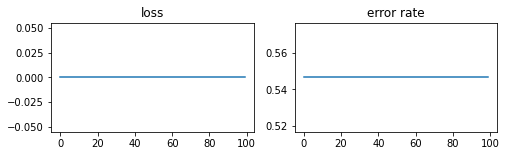

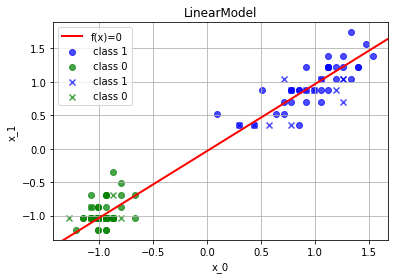

In [ ]:
def test_model(modelclass, w0=[-3.0, 3.0, 0.1], reg=0.1, stepsize=.2, plot=False):
    """Create instance of modelclass, train it, compute test error,
    plot learning curves and decision boundary.
    """
    model = modelclass(w0, reg)
    print('Initial weights: ', model.w)
    training_loss, training_error = model.train(trainset, stepsize, 100, plot=plot)
    print("The test error is {:.2f}%".format(
      model.error_rate(testset[:,:-1], testset[:,-1])*100))
    print('Final weights: ', model.w)

    # learning curves
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8,2))
    ax0.plot(training_loss)
    ax0.set_title('loss')
    ax1.plot(training_error)
    ax1.set_title('error rate')

    # data plot
    plt.figure()
    scatter(trainset, marker='o')
    scatter(testset, marker='x')
    decision_boundary(model.w)
    finalize_plot(modelclass.__name__)

test_model(LinearModel)

## 4. Linear Regression

**Exercise:** Complete the `loss` and `gradient` methods in `LinearRegression`.

1. Linear regression with MSE: $g(\mathbf{w}; \mathbf{x}, y) = \frac{1}{2}(\mathbf{x}^T \mathbf{w} - y)^2$.

Initial weights:  [-3.   3.   0.1]
Training completed: the train error is 0.00%
The test error is 0.00%
Final weights:  [ 0.24  0.69 -0.01]


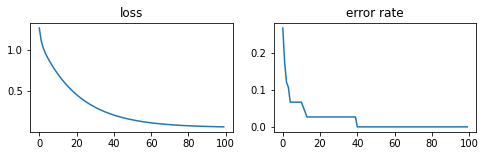

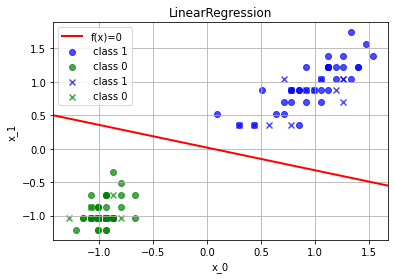

In [ ]:
# Question 2

class LinearRegression(LinearModel):

    def __init__(self, w0, reg):
        super().__init__(w0, reg)

    def loss(self, X, y):
        """Computes the mean loss for batch X.
        Takes as input a matrix X and a vector y.
        Returns a scalar.
        """
        # WRITE CODE HERE
        return 0.5 * np.mean ((self.predict(X)-y)**2)+ self.reg*0.5*np.sum(self.w**2)

    def gradient(self, X, y):
        """Computes gradient of the loss with respect to w for a batch X.
        Takes as input a matrix X and a vector y.
        Returns a vector with the same shape as w.
        """
        # WRITE CODE HERE
        return ((self.predict(X)-y)[:, np.newaxis]*X).mean(axis=0)+self.reg*self.w

test_model(LinearRegression)

## 5. Perceptron

**Exercise:** Complete the `loss` and `gradient` methods in `Perceptron`.

2. Perceptron: $g(\mathbf{w}; \mathbf{x}, y) = \max(0, -y\ \mathbf{x}^T \mathbf{w})$.

Initial weights:  [-3.   3.   0.1]
Training completed: the train error is 0.00%
The test error is 0.00%
Final weights:  [-1.55  3.86 -0.03]


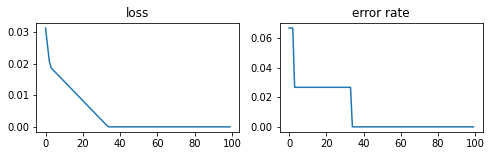

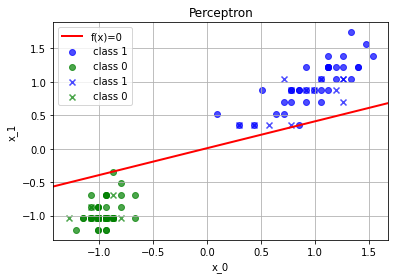

In [ ]:
# Question 3

class Perceptron(LinearModel):

    def __init__(self, w0, reg):
        super().__init__(w0, reg)

    def loss(self, X, y):
        """Computes the mean loss for batch X.
        Takes as input a matrix X and a vector y.
        Returns a scalar.
        """
        # WRITE CODE HERE
        return np.mean(np.maximum(0, -y*self.predict(X))) + 0.5 *self.reg* np.sum(self.w**2)

    def gradient(self, X, y):
        """Computes gradient of the loss with respect to w for a batch X.
        Takes as input a matrix X and a vector y.
        Returns a vector with the same shape as w.
        """
        # WRITE CODE HERE
        activation = (-y*self.predict(X)>0).astype(float)
        return -((y*activation)[:, np.newaxis]*X).mean(axis=0)+self.reg*self.w

test_model(Perceptron, reg=0.0, stepsize=1)

## 6. SVM

**Exercise:** Complete the `loss` and `gradient` methods in `SVM`.

3. SVM: $g(\mathbf{w}; \mathbf{x}, y) = \max(0, 1 - y\ \mathbf{x}^T \mathbf{w})$.

Initial weights:  [-3.   3.   0.1]
Training completed: the train error is 0.00%
The test error is 0.00%
Final weights:  [0.77 0.62 0.15]


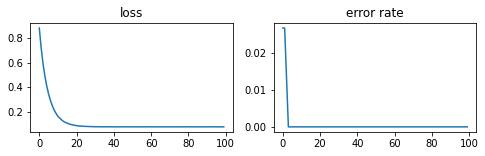

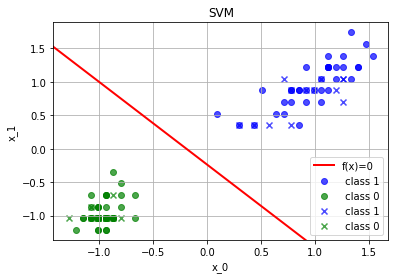

In [ ]:
# Question 4

class SVM(LinearModel):

    def __init__(self, w0, reg):
        super().__init__(w0, reg)

    def loss(self, X, y):
        """Computes the mean loss for batch X.
        Takes as input a matrix X and a vector y.
        Returns a scalar.
        """
        # WRITE CODE HERE
        return np.mean(np.maximum(0, 1 -y*self.predict(X))) + 0.5 *self.reg* np.sum(self.w**2)

    def gradient(self, X, y):
        """Computes gradient of the loss with respect to w for a batch X.
        Takes as input a matrix X and a vector y.
        Returns a vector with the same shape as w.
        """
        # WRITE CODE HERE
        activation = (1 - y*self.predict(X)>0).astype(float)
        return -((y*activation)[:, np.newaxis]*X).mean(axis=0)+self.reg*self.w


test_model(SVM, reg=0.1, stepsize=1)

## 7. Logistic Regression

**Exercise:** Complete the `loss` and `gradient` methods in `LogisticRegression`.

4. Logistic regression: $g(\mathbf{w}; \mathbf{x}, y) = \log( 1 + e^{- y\ \mathbf{x}^T \mathbf{w}})$.

Initial weights:  [-3.   3.   0.1]
Training completed: the train error is 0.00%
The test error is 0.00%
Final weights:  [0.7  1.43 0.01]


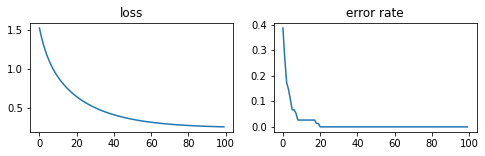

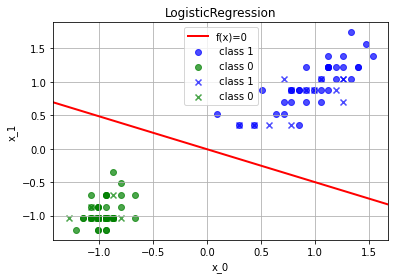

In [ ]:
# Question 5

class LogisticRegression(LinearModel):

    def __init__(self, w0, reg):
        super().__init__(w0, reg)

    def loss(self, X, y):
        """Computes the mean loss for batch X.
        Takes as input a matrix X and a vector y.
        Returns a scalar.
        """
        # WRITE CODE HERE
        return np.mean(np.log(1+ np.exp(-y*self.predict(X))))+ 0.5*self.reg*np.sum(self.w**2)

    def gradient(self, X, y):
        """Computes gradient of the loss with respect to w for a batch X.
        Takes as input a matrix X and a vector y.
        Returns a vector with the same shape as w.
        """
        # WRITE CODE HERE
        prob = 1 / (1+np.exp(y*self.predict(X)))
        return ((prob*-y)[:, np.newaxis]*X).mean(axis=0)+self.reg*self.w

test_model(LogisticRegression)

## Conclusion

All done! You've now trained 4 models with the most common losses in machine learning!

To be exact, the perceptron loss is not used anymore. Do you know why?

Can you spot a difference in behavior compared to the SVM loss when you play with hyperparameters or set a random initialization?

What can you tell about the behavior of the decision boundary with different experiments?

Nowadays, machine learning datasets are so large that we use stochastic gradient descent instead of full batch gradient descent. You can try and implement this in the base class `LinearModel`. 

You may also explore different hyperparameters and observe your graph functions!